# Setup

In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# enhanced stats functions
from scipy import stats

# for ease of data profiling
from pandas_profiling import ProfileReport

In [2]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1
print(f"seaborn version : {sns.__version__}") # 0.11.2

pandas version  : 1.3.5
numpy version   : 1.22.1
seaborn version : 0.11.2


Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

In [3]:
SEED = 123
np.random.seed(SEED)

# Data Loading
To load in the data for this project, read in `insurance.csv` into a variable called `df` as a pandas DataFrame. The first two rows of the DataFrame should look like this:

|       | age | sex     | bmi    | children | smoker | region    | charges     |
| ----- | --- | ------- | ------ | -------- | ------ | --------- | ----------- |
| **0** | 19  | female  | 27.900 | 0        | yes    | southwest | 16884.92400 |
| **1** | 18  | male    | 33.770 | 1        | no     | southeast | 1725.55230  |

In [21]:
# read in data
df = pd.read_csv('insurance.csv')

In [22]:
# make sure data was read in properly and matches above table
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


# EDA
Now it is time for you to practice your EDA skills! Take a look at the Quest 2 Quiz, and answer the first 5 questions on the results of your EDA on the dataset.

**Data dictionary**

| column | data definition | 
| --- | --- | 
| age | age of insured person | 
| sex | sex of insured person, either male or female | 
| bmi | body mass index of insured person |
| children | number of dependents covered by health insurance |
| smoker | does the insured person smoke? |
| region | the insured person's residential area within the US |
| charges | medical costs billed by health insurance; target variable |

For additional information, check the dataset's [information on Kaggle](https://www.kaggle.com/datasets/mirichoi0218/insurance).

In [6]:
# optional: use pandas-profiling to do quick first pass at EDA
profile = ProfileReport(df, title="Insurance Dataset Profiling Report")
# create html file to view report
profile.to_file("insurance_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
# conduct any other EDA that you need to in order to get a good feel for the data
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


With the EDA you have conducted, answer the following questions from the quiz. Note that these questions do not cover everything you should be looking for when doing EDA, they are just to give you an idea of what EDA would look like on such a dataset.
## Question 1
What is the median age of the individuals in our dataset?

In [24]:
# calculate median age
df.age.median()

39.0

## Question 2
What is the index of the person who has the highest BMI?

In [25]:
# find index of person with highest BMI
high = df.sort_values('bmi', ascending = False)
high.head(1).index

Int64Index([1317], dtype='int64')

## Question 3
Which two independent numeric variables (excluding categorical and dummy variables) are most highly correlated with each other?

<AxesSubplot:>

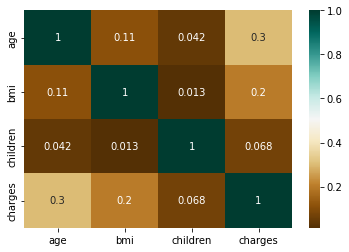

In [26]:
# plot correlation heatmap 
sns.heatmap(df.corr(),annot=True, cmap='BrBG')

## Question 4
What is the distribution of the `charges` variable in our dataset?

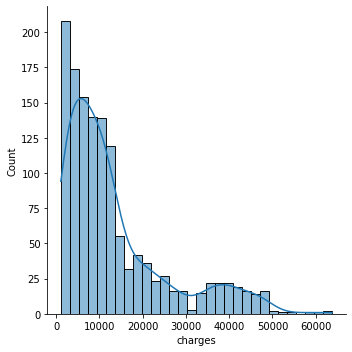

In [27]:
# plot distribution of charges
sns.displot(x='charges', data=df, kde=True)

That's strange, that doesn't look like our data is normally distributed. While you can theoretically still apply linear regression to a distribution which isn't normally distributed, it's generally best practice for your data to be normal. Looks like we may need to transform our data in some way in order to get it closer to a normal distribution.

Create a new column in df, `log_charges`, by taking the log of the existing `charges` column. Then, drop the `charges` column. Your first two rows should now look like:

|       | age | sex     | bmi    | children | smoker | region    | log_charges |
| ----- | --- | ------- | ------ | -------- | ------ | --------- | ----------- |
| **0** | 19  | female  | 27.900 | 0        | yes    | southwest | 9.734176    |
| **1** | 18  | male    | 33.770 | 1        | no     | southeast | 7.453302    |

In [28]:
# take log of charges, then drop old column
df["log_charges"] = np.log(df.charges)
df.drop(columns = 'charges', inplace=True)

In [29]:
# check if your table matches the one above
df.head(2)

,age,sex,bmi,children,smoker,region,log_charges
0,19,female,27.90,0,yes,southwest,9.734176
1,18,male,33.77,1,no,southeast,7.453302


Great, now plot the new distribution to see whether it's a normal distribution.

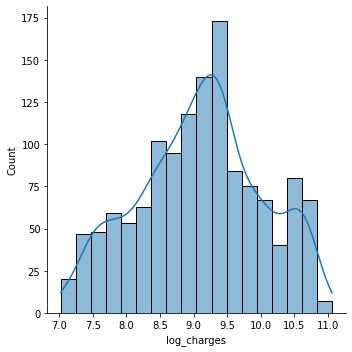

In [30]:
# plot distribution for log_charges
sns.displot(x='log_charges', data=df, kde=True)

Note that even after log transforming our data, it is still not normally distributed. But it is now closer to a normal distribution than the data originally was, so we can continue on with our analysis using this new variable `log_charges` variable as our target variable instead!

### Optional exploration
Are there other ways of determining whether the data is normally distributed or not, besides looking at the above plot? Hint: they're in the stats package we already imported from scipy!

## Question 5
There are two rows which are identical to each other; what are their indexes?

In [31]:
# find indexes of duplicatedrows
df[df.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,log_charges
195,19,male,30.59,0,no,northwest,7.402185
581,19,male,30.59,0,no,northwest,7.402185


# Data Wrangling
Now that we have an idea of what our data looks like, we need to start preparing it for modelling.

In this case, we don't have any missing data, so we don't need to do anything about that. We have one duplicated row, but that seems to be legitimate data, so we will keep it in. 

We have 3 categorical variables - sex, smoker, and region. Get dummy variables using pandas, ensuring to use the `drop_first=True` argument to mitigate possible multicollinearity issues. As a result, you should only have one dummy variable for binary values such as `sex` or `smoker`. 

In [32]:
# get dummies for sex, smoker, and region
dummy = pd.get_dummies(df[['sex','smoker','region']], drop_first = True)

In [33]:
df = pd.concat([df, dummy],axis=1)

In [34]:
df.drop(columns = ['sex','smoker','region'], inplace=True)

In [35]:
df.head()

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734176,0,1,0,0,1
1,18,33.770,1,7.453302,1,0,0,1,0
2,28,33.000,3,8.400538,1,0,0,1,0
3,33,22.705,0,9.998092,1,0,1,0,0
4,32,28.880,0,8.260197,1,0,1,0,0


Now verify that we still don't have major multicollinearity issues with a heatmap. What we're looking for is that most of the correlations between independent variables should still be relatively low. There's no single cut-off value (much of this is as much an art as it is a science), but we'll say for our purposes here that we'll consider anything between -0.5 and 0.5 to be low.

Note that if a variable is strongly correlated with our dependent variable `log_charges`, that's okay. If anything, that's probably a good thing!

<AxesSubplot:>

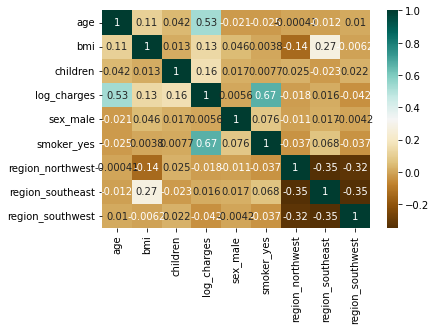

In [36]:
# correlation plot heatmap
sns.heatmap(df.corr(),annot=True, cmap='BrBG')

## Question 6
After getting dummy variables from our categorical variables, how many independent variables do we have?

In [37]:
# get number of independent variables
df.columns.to_list()

['age',
 'bmi',
 'children',
 'log_charges',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest']

Now separate our independent variables into a variable called `X`, and our target variable `log_charges` into a variable called `y`.

In [38]:
# split up our variables
X = df[['age','bmi','children','sex_male','smoker_yes',
     'region_northwest','region_southeast','region_southwest']]
y = df['log_charges']

In [39]:
# the resulting shapes of X and y should be (1338, 8) and (1338,) respectively
print(X.shape)
print(y.shape)

(1338, 8)
(1338,)


Now we need to split up our data into training and test data. Using scikit-learn's `train_test_split` function, using a `test_size` of 0.3 (i.e. 30% of data in test set), and **ensure that the random state is set to our seed from above**.

Documentation for `train_test_split()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.model_selection.train_test_split.html

In [40]:
# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=np.random.seed(SEED))

### Question 7
What are the indexes for the first five data points in the training dataset after train_test_split?

In [41]:
X_train.head().index

Int64Index([300, 904, 670, 617, 373], dtype='int64')

# Modelling and Evaluation
Now we can make our model! Instantiate a LinearRegression model in scikit-learn, then fit the training data on it.

Documentation for `LinearRegression()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.linear_model.LinearRegression.html

In [42]:
# instantiate linear regression model and fit the training data to it
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [43]:
# describe model
print(f"intercept: {lr.intercept_:.4f}")
for i in range(len(X_train.columns)):
    print(f"{X_train.columns[i]}: {lr.coef_[i]:.4f}")

intercept: 6.9877
age: 0.0347
bmi: 0.0151
children: 0.1070
sex_male: -0.0837
smoker_yes: 1.5320
region_northwest: -0.0879
region_southeast: -0.1546
region_southwest: -0.1433


Now we need to evaluate how our model did. Let's start by gathering some basic metrics on the training data (e.g. MAE, RMSE, R^2), then do the same on the test set.

In [44]:
# predict training set values
predictions_train = lr.predict(X_train)

In [45]:
# evaluate model R^2 (score)
r2_train = r2_score(y_train, predictions_train)

In [46]:
# evaluate model MAE
mae_train = mean_absolute_error(y_train, predictions_train)

In [47]:
# evaluate model RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

In [48]:
# print metrics
print("metrics for training data")
print(f"R^2 score : {r2_train:.4f}")
print(f"mae       : {mae_train:.4f}")
print(f"rmse      : {rmse_train:.4f}")

metrics for training data
R^2 score : 0.7608
mae       : 0.2880
rmse      : 0.4557


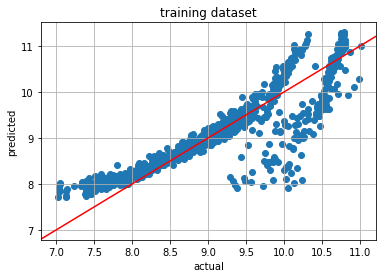

In [50]:
# plot predictions against actual values
plt.scatter(y_train, predictions_train)
plt.title("training dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

Clearly, while our model has clearly learned something about the data, there is still room for improvement.

Now we're going to evaluate our model's performance on the test set. First, we need to make our model predict the values for the test set.

In [51]:
# make predictions on test set
predictions_test = lr.predict(X_test)

In [52]:
# get same metrics as before - R^2, MAE, RMSE
r2_test = r2_score(y_test, predictions_test)
mae_test = mean_absolute_error(y_test, predictions_test)
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

In [53]:
# print metrics
print("metrics for test data")
print(f"R^2 score : {r2_test:.4f}")
print(f"mae       : {mae_test:.4f}")
print(f"rmse      : {rmse_test:.4f}")

metrics for test data
R^2 score : 0.7841
mae       : 0.2697
rmse      : 0.4129


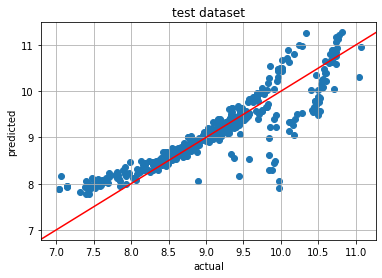

In [54]:
# plot predictions against actual values
plt.scatter(y_test, predictions_test)
plt.title("test dataset")
plt.xlabel("actual")
plt.ylabel("predicted")
plt.gca().axline([7, 7], [11, 11], color="red")
plt.grid()

## Question 8
Are the residuals normally distributed?

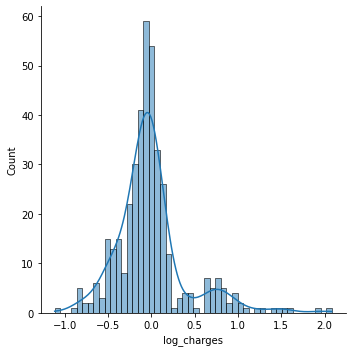

In [55]:
# plot residuals to determine if they are normally distributed
sns.displot((y_test-predictions_test), bins=50, kde=True)

Now, let's take a step back. We know that we took the log of `charges` in order to make it closer to a normal distribution. While this is helpful for our modelling, at the end of the day we want to predict the actual insurance charges, not the log of them.

## Question 9
What are the predicted insurance charges for index 650 (the first row in the test dataset), rounded to 2 decimal places (i.e. nearest cent)?

In [56]:
# get predicted insurance charge for index 650
charge = y_test[650]

In [57]:
# get the predicted insurance charges
print(f"predicted insurance charges: {charge:.2f}")

predicted insurance charges: 9.19


# Discussion
While our model has learned some of the relationships from the data, it is still imperfect. What else could we do to improve it? Here are some possibilities:
1. We did not normalize/standardize our data, which could result in larger numeric variables (e.g. age) having a larger impact on the final result than smaller numeric variables (e.g. children). For more on normalization and standardization, check out [this resource](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/).
2. As our region dummy variables seem somewhat negatively correlated with each other, perhaps we may have issues with multicollinearity. So we could try encoding the region variable differently, separating into just 2 variables, one for north/south and the other for east/west.
3. Perhaps some of the variables interact with each other. We could try adding additional features covering such interactions (e.g. smoking & sex, region & bmi, etc.). Check out [this resource for more information on interaction effects](https://stattrek.com/multiple-regression/interaction).
4. Instead of normalizing our `charges` value by taking the log of it, we could do a Box-Cox transformation instead. Check out [this resource for more on Box-Cox transformation](https://towardsdatascience.com/box-cox-transformation-explained-51d745e34203).

Implementing any of the suggested potential improvements to the model are left as an exercise to the reader ;)

# Prepare your Submission
Congratulations, you made it to the end of this lesson! Be sure to complete the remaining few quiz questions, and prepare your submission:
1. Replace the value of the `NAME` variable with your StackUp name.
2. Edit the last cell in the notebook so that it reflects the requested data, rather than the placeholder values below. Make sure you read what it is asking for, and replicate all the features of it - this includes axis labels, which charts go where, etc.  
3. Restart your notebook, then run it from start to end.
4. Take a screenshot of the output from the last cell in this notebook. Make sure your screenshot shows your taskbar/dock (i.e. take a screenshot of the whole screen, not just the window).

e.g. This section of code currently produces placeholder values:  

```print(f"Predicted insurance charges: {np.random.random()*10000:.2f}")```

You must replace `np.random.random()*10000` so that it reflects the value you obtained for the predicted insurance charge of index 650.

In [58]:
# replace this with your StackUp name
NAME = "Nerdsolomon"

Name                : Nerdsolomon
intercept           : 0.6792
age                 : 0.5961
bmi                 : 0.8088
children            : 0.1562
sex_male            : -0.0469
smoker_yes          : -0.7009
region_northwest    : 0.0520
region_southeast    : 0.9352
region_southwest    : -0.6268
------------------------
Predicted insurance charges: 9.19


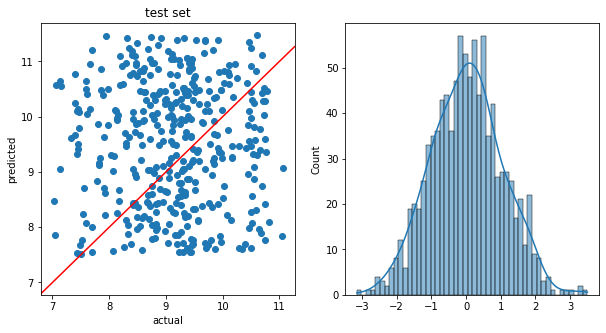

In [65]:
# run this cell, then take a screenshot of the result
print(f"{'Name':<20}: {NAME}")
# describe model
print(f"{'intercept':<20}: {np.random.random():.4f}")
for col in X_train.columns:
    print(f"{col:<20}: {np.random.random()*2-1:.4f}")
print("---"*8)
# get predicted insurance charge for index 650
print(f"Predicted insurance charges: {charge:.2f}")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,5)

# draw plots for test set
# ax1 - scatter plot of predictions vs actual
ax1.scatter(y_test, np.random.random(y_test.shape)*4+7.5)
ax1.axline([7, 7], [11, 11], color="red")
ax1.set_title("test set")
ax1.set_xlabel("actual")
ax1.set_ylabel("predicted")

# ax2 - residuals plot
sns.histplot(np.random.normal(size=1000), bins=50, kde=True, ax=ax2)

plt.show()